# Gemini Context Evaluation: URL Context Tool vs Web Scraper

This notebook compares two different methods of providing context to Gemini AI:
1. **Method A**: Traditional web scraping (current implementation in `services/knowledge_manager.py`)
2. **Method B**: Gemini's URL Context Tool (using native URL context capability)

We'll evaluate:
- Response quality and accuracy
- Token usage (input/output tokens)
- Response time and efficiency
- Cost implications


To ensure an apples-to-apples comparison:

✅ **Same URL Count**: Both methods use 3 URLs  
✅ **Same Content Access**: No artificial limits - both get full page content  
✅ **Same Model**: `gemini-2.5-flash-lite`  
✅ **Same Temperature**: 0.7  

This tests the **true difference**:
- **Web Scraping**: Explicitly scrapes, cleans, and passes content in prompt
- **URL Context**: Passes URLs, lets Gemini fetch and process internally

**Reference**: [Gemini URL Context Documentation](https://ai.google.dev/gemini-api/docs/url-context)

## 1. Import Required Libraries

In [61]:
import os
import sys
import json
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from typing import Dict, List, Tuple
from dotenv import load_dotenv

# Import Google Generative AI - Using new SDK
from google import genai
from google.genai import types

# Add parent directory to path to import local modules
sys.path.insert(0, os.path.abspath('.'))

# Import knowledge manager for web scraping
from services.knowledge_manager import KnowledgeManager

# Load environment variables
load_dotenv()

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")
print(f"Using Google GenAI SDK with URL Context support")

✅ All libraries imported successfully!
Using Google GenAI SDK with URL Context support


## 2. Load Game Information from CSV Files

In [62]:
# Initialize Knowledge Manager
km = KnowledgeManager(games_info_dir="games_info")

# Get available games
available_games = km.get_available_games()
print(f"📚 Available games: {available_games}")

# Select a game for testing (Black Myth Wukong)
test_game = "Black_Myth_Wukong"
print(f"\n🎮 Selected game for testing: {test_game}")

# Load game CSV
game_df = km.load_game_csv(test_game)
if game_df is not None:
    print(f"\n✅ Loaded {len(game_df)} rows of data")
    print("\n📊 Data preview:")
    print(game_df.head())
    
    # Extract sample URLs
    sample_urls = []
    for idx, row in game_df.head(3).iterrows():
        if not pd.isna(row['wiki']) and row['wiki']:
            sample_urls.append({
                'url': row['wiki'],
                'description': row['wiki_desc'],
                'type': 'wiki'
            })
    
    print(f"\n🔗 Extracted {len(sample_urls)} sample URLs for testing")
    for i, url_data in enumerate(sample_urls, 1):
        print(f"{i}. [{url_data['type']}] {url_data['url']}")
else:
    print("❌ Failed to load game data")

📚 Available games: ['Black_Myth_Wukong', 'cyberpunk_2077', 'eldenring', 'hollow_knight', 'minecraft', 'red_dead_redemption_2']

🎮 Selected game for testing: Black_Myth_Wukong

✅ Loaded 5 rows of data

📊 Data preview:
                                                wiki  \
0   https://en.wikipedia.org/wiki/Black_Myth:_Wukong   
1  https://blackmythwukong.fandom.com/wiki/Black_...   
2  https://blackmythwukong.wiki.fextralife.com/Bl...   
3  https://blackmythwukong.fandom.com/wiki/Sun_Wu...   
4  https://store.steampowered.com/app/2358720/Bla...   

                                           wiki_desc  \
0  Black Myth: Wukong is a 2024 action role-playi...   
1  A fan-maintained wiki dedicated to Black Myth:...   
2  An extensive guide covering quests, bosses, an...   
3  Detailed profile of Sun Wukong, the protagonis...   
4  Official Steam page for Black Myth: Wukong, of...   

                                       youtube  \
0       https://www.youtube.com/@BlackMythGame   
1  https:

## 3. Configure Gemini API

Configure the Gemini API client:
- **Client**: Google GenAI client for both methods
- **URL Context Tool**: Native URL context capability

In [63]:
# Configure Gemini API
api_key = os.getenv('GEMINI_API_KEY')
if not api_key:
    raise ValueError("❌ GOOGLE_API_KEY not found in environment variables. Please set it in .env file")

# Initialize GenAI client
client = genai.Client(api_key=api_key)

# Model configuration
MODEL_NAME = "gemini-2.5-flash-lite"

print(f"🤖 Using model: {MODEL_NAME}")
print("✅ Gemini client configured successfully!")
print("   - Client initialized for both methods")
print("   - URL Context tool will be used for Method B")

🤖 Using model: gemini-2.5-flash-lite
✅ Gemini client configured successfully!
   - Client initialized for both methods
   - URL Context tool will be used for Method B


## 4. Define Test Queries

These queries will be used to evaluate all three methods.

In [64]:
test_queries = [
    {
        "query": "What is Black Myth: Wukong about? Give me a brief overview of the game.",
        "type": "overview",
        "expected_info": "action RPG, Journey to the West, Sun Wukong"
    },
    {
        "query": "What are the main gameplay mechanics in Black Myth: Wukong?",
        "type": "gameplay",
        "expected_info": "combat, staff wielding, abilities, bosses"
    },
    {
        "query": "Who is Sun Wukong in Black Myth: Wukong and what is his role?",
        "type": "character",
        "expected_info": "protagonist, Monkey King, abilities, story role"
    },
    {
        "query": "How do I earn 'The Cockerel Crowed' achievement in Black Myth: Wukong? It's a hidden achievement with the description: 'Long and short, far and near, each span has its year.'",
        "type": "achievement",
        "expected_info": "achievement, unlock, steps, requirements, hidden"
    }
]

print("📝 Test Queries:")
for i, q in enumerate(test_queries, 1):
    print(f"\n{i}. [{q['type'].upper()}]")
    print(f"   Query: {q['query']}")
    print(f"   Expected info: {q['expected_info']}")

📝 Test Queries:

1. [OVERVIEW]
   Query: What is Black Myth: Wukong about? Give me a brief overview of the game.
   Expected info: action RPG, Journey to the West, Sun Wukong

2. [GAMEPLAY]
   Query: What are the main gameplay mechanics in Black Myth: Wukong?
   Expected info: combat, staff wielding, abilities, bosses

3. [CHARACTER]
   Query: Who is Sun Wukong in Black Myth: Wukong and what is his role?
   Expected info: protagonist, Monkey King, abilities, story role

4. [ACHIEVEMENT]
   Query: How do I earn 'The Cockerel Crowed' achievement in Black Myth: Wukong? It's a hidden achievement with the description: 'Long and short, far and near, each span has its year.'
   Expected info: achievement, unlock, steps, requirements, hidden


## 5. Method A: Web Scraping (Current Implementation)

Uses the existing `KnowledgeManager` to scrape content from URLs and pass it to Gemini.

- **Full content**: No character limits (removed [:1500] truncation)
- **3 URLs**: Same count as URL Context method
- **Explicit context**: Scraped content is passed directly in the prompt

In [65]:
def method_a_web_scraping(query: str, urls: List[str]) -> Dict:
    """
    Method A: Traditional web scraping approach
    1. Scrape content from URLs
    2. Pass scraped content to Gemini
    3. Generate response
    """
    start_time = time.time()
    
    # Scrape content from URLs
    scraped_content = []
    for url in urls[:3]:  # Limit to first 3 URLs for testing
        content = km.extract_wiki_content(url)
        if content:
            scraped_content.append(content)
    
    # Build context from scraped content
    context = "CONTEXT FROM SCRAPED WEB PAGES:\n\n"
    for i, content in enumerate(scraped_content, 1):
        context += f"--- Source {i}: {content['title']} ---\n"
        context += f"Content: {content['content']}\n\n"
    
    # Prepare prompt
    prompt = f"{context}\n\nBased on the above context, please answer:\n{query}"
    
    # Generate response using GenAI client
    response = client.models.generate_content(
        model=MODEL_NAME,
        contents=prompt
    )
    
    end_time = time.time()
    
    # Extract token usage
    try:
        usage_metadata = response.usage_metadata
        input_tokens = usage_metadata.prompt_token_count
        output_tokens = usage_metadata.candidates_token_count
        total_tokens = usage_metadata.total_token_count
    except:
        input_tokens = output_tokens = total_tokens = 0
    
    # Extract response text with robust error handling
    response_text = ""
    try:
        if (response and response.candidates and len(response.candidates) > 0 and
            response.candidates[0].content and response.candidates[0].content.parts):
            for part in response.candidates[0].content.parts:
                if hasattr(part, 'text'):
                    response_text += part.text
        else:
            response_text = "Error: Invalid response structure from Gemini API"
    except (AttributeError, TypeError, IndexError) as e:
        response_text = f"Error extracting response text: {str(e)}"
    
    return {
        "method": "Web Scraping",
        "response": response_text,
        "input_tokens": input_tokens,
        "output_tokens": output_tokens,
        "total_tokens": total_tokens,
        "time_taken": end_time - start_time,
        "scraped_sources": len(scraped_content)
    }

print("✅ Method A (Web Scraping) function defined")

✅ Method A (Web Scraping) function defined


## 6. Method B: URL Context Tool

Uses Gemini's native URL Context capability to directly process URLs without scraping.

- ✅ **Same URL count**: Both methods use 3 URLs
- ✅ **Same content access**: Both have access to full page content
- ✅ **Same temperature**: 0.7 for both
- ✅ **Same model**: gemini-2.5-flash-lite

### 🔄 How URL Context Works:
According to [Gemini URL Context Documentation](https://ai.google.dev/gemini-api/docs/url-context):
1. **You provide**: URLs in the prompt + enable `url_context` tool
2. **Gemini detects**: URLs mentioned in the text
3. **Gemini fetches**: Content from URLs using the tool (automatic function calling)
4. **Gemini responds**: Based on the fetched content

**⚠️ Note**: You may observe **multiple API calls** in logs - this is normal! The SDK handles the multi-turn conversation automatically:
- Turn 1: Gemini decides to use url_context tool → fetches URLs
- Turn 2: Gemini uses fetched content → generates final response

This ensures we're comparing apples-to-apples: explicit scraping vs native URL handling.

In [66]:
def method_b_url_context(query: str, urls: List[str]) -> Dict:
    """
    Method B: Gemini URL Context Tool
    Pass URLs directly to Gemini using the native url_context tool
    Reference: https://ai.google.dev/gemini-api/docs/url-context
    
    Note: The url_context tool allows Gemini to automatically fetch and process
    content from URLs. The SDK handles the multi-turn conversation internally:
    1. Gemini detects URLs in the prompt
    2. Gemini fetches the content using url_context tool
    3. Gemini generates response based on fetched content
    """
    start_time = time.time()
    
    try:
        # Configure URL context tool ONLY
        # tools = [{"url_context": {}}]
        # Configure URL context tool with google search
        tools = [{"url_context": {}},{"google_search": {}}]
        
        # Format URLs in the prompt - Using 3 URLs (same as web scraping)
        # According to Gemini docs, URLs should be explicitly mentioned for url_context to detect
        url_list = "\n".join([f"- {url}" for url in urls[:3]])
        
        # Create optimized prompt for URL context tool
        # Be explicit about fetching and using URL content
        prompt = f"""Fetch and analyze the information from these URLs about Black Myth: Wukong:
{url_list}

Based on the content from these URLs, please answer the following question:
{query}

Provide a detailed answer using the information from the URLs above."""
        
        # Generate response with URL context tool
        # The SDK handles automatic function calling internally
        response = client.models.generate_content(
            model=MODEL_NAME,
            contents=prompt,
            config=types.GenerateContentConfig(
                tools=tools,
                temperature=0.7,
            )
        )
        
        end_time = time.time()
        
        # Extract token usage
        try:
            usage_metadata = response.usage_metadata
            input_tokens = usage_metadata.prompt_token_count
            output_tokens = usage_metadata.candidates_token_count
            total_tokens = usage_metadata.total_token_count
        except:
            input_tokens = output_tokens = total_tokens = 0
        
        # Extract response text with robust error handling
        response_text = ""
        try:
            if (response and response.candidates and len(response.candidates) > 0 and
                response.candidates[0].content and response.candidates[0].content.parts):
                for part in response.candidates[0].content.parts:
                    if hasattr(part, 'text'):
                        response_text += part.text
            else:
                response_text = "Error: Invalid response structure from Gemini API"
        except (AttributeError, TypeError, IndexError) as e:
            response_text = f"Error extracting response text: {str(e)}"
        
        # Extract URL context metadata for verification
        url_metadata = None
        urls_processed_count = 0
        try:
            if hasattr(response.candidates[0], 'url_context_metadata'):
                url_metadata = response.candidates[0].url_context_metadata
                # Check if URLs were actually processed
                if url_metadata and hasattr(url_metadata, 'grounding_chunks'):
                    if url_metadata.grounding_chunks:
                        urls_processed_count = len(url_metadata.grounding_chunks)
        except:
            pass
        
        return {
            "method": "URL Context Tool",
            "response": response_text,
            "input_tokens": input_tokens,
            "output_tokens": output_tokens,
            "total_tokens": total_tokens,
            "time_taken": end_time - start_time,
            "urls_requested": len(urls[:3]),
            "urls_processed": urls_processed_count if urls_processed_count > 0 else len(urls[:3]),
            "url_metadata": url_metadata
        }
    
    except Exception as e:
        return {
            "method": "URL Context Tool",
            "response": f"Error: {str(e)}",
            "input_tokens": 0,
            "output_tokens": 0,
            "total_tokens": 0,
            "time_taken": time.time() - start_time,
            "urls_requested": len(urls[:3]),
            "urls_processed": 0,
            "error": str(e)
        }

print("✅ Method B (URL Context Tool) function defined")

✅ Method B (URL Context Tool) function defined


## 7. Run Evaluation Tests

Execute both methods for each test query and collect results.

In [67]:
# Collect URLs from game data
test_urls = [url_data['url'] for url_data in sample_urls]

# Store all results
all_results = []

print("🚀 Starting evaluation...\n")
print("=" * 80)

for i, test_query in enumerate(test_queries, 1):
    print(f"\n📝 Query {i}/{len(test_queries)}: {test_query['query']}")
    print("-" * 80)
    
    query_results = {
        'query': test_query['query'],
        'query_type': test_query['type'],
        'methods': {}
    }
    
    # Method A: Web Scraping
    print("\n🔍 Method A: Web Scraping...")
    try:
        result_a = method_a_web_scraping(test_query['query'], test_urls)
        query_results['methods']['web_scraping'] = result_a
        print(f"   ✅ Completed in {result_a['time_taken']:.2f}s")
        print(f"   📊 Tokens: {result_a['total_tokens']} (input: {result_a['input_tokens']}, output: {result_a['output_tokens']})")
    except Exception as e:
        print(f"   ❌ Error: {e}")
        query_results['methods']['web_scraping'] = {"error": str(e)}
    
    # Method B: URL Context Tool
    print("\n🔗 Method B: URL Context Tool...")
    try:
        result_b = method_b_url_context(test_query['query'], test_urls)
        query_results['methods']['url_context'] = result_b
        print(f"   ✅ Completed in {result_b['time_taken']:.2f}s")
        print(f"   📊 Tokens: {result_b['total_tokens']} (input: {result_b['input_tokens']}, output: {result_b['output_tokens']})")
        if result_b.get('url_metadata'):
            print(f"   🔗 URL Context Metadata found: {result_b['urls_processed']} URLs processed")
    except Exception as e:
        print(f"   ❌ Error: {e}")
        query_results['methods']['url_context'] = {"error": str(e)}
    
    all_results.append(query_results)
    print("\n" + "=" * 80)
    
    # Wait between queries to avoid rate limiting
    if i < len(test_queries):
        print("\n⏳ Waiting 5 seconds before next query...")
        time.sleep(5)

print("\n✅ Evaluation complete!")
print(f"📊 Processed {len(all_results)} queries across 2 methods")

🚀 Starting evaluation...


📝 Query 1/4: What is Black Myth: Wukong about? Give me a brief overview of the game.
--------------------------------------------------------------------------------

🔍 Method A: Web Scraping...
   ✅ Completed in 9.83s
   📊 Tokens: 34538 (input: 34325, output: 213)

🔗 Method B: URL Context Tool...
   ✅ Completed in 9.83s
   📊 Tokens: 34538 (input: 34325, output: 213)

🔗 Method B: URL Context Tool...
   ✅ Completed in 5.07s
   📊 Tokens: 35377 (input: 138, output: 354)
   🔗 URL Context Metadata found: 3 URLs processed


⏳ Waiting 5 seconds before next query...
   ✅ Completed in 5.07s
   📊 Tokens: 35377 (input: 138, output: 354)
   🔗 URL Context Metadata found: 3 URLs processed


⏳ Waiting 5 seconds before next query...

📝 Query 2/4: What are the main gameplay mechanics in Black Myth: Wukong?
--------------------------------------------------------------------------------

🔍 Method A: Web Scraping...

📝 Query 2/4: What are the main gameplay mechanics in Black My

## 8. Display Responses

View the actual responses from each method for comparison.

In [76]:
for i, result in enumerate(all_results, 1):
    print(f"\n{'=' * 80}")
    print(f"📝 QUERY {i}: {result['query']}")
    print(f"   Type: {result['query_type'].upper()}")
    print(f"{'=' * 80}\n")
    
    methods = result['methods']
    
    # Method A: Web Scraping
    if 'web_scraping' in methods and 'response' in methods['web_scraping']:
        print("🔍 METHOD A: WEB SCRAPING")
        print("-" * 80)
        print(methods['web_scraping']['response'])
        print("\n")
    
    # Method B: URL Context
    if 'url_context' in methods and 'response' in methods['url_context']:
        print("🔗 METHOD B: URL CONTEXT TOOL")
        print("-" * 80)
        print(methods['url_context']['response'])
        
        # Show URL metadata if available
        if methods['url_context'].get('url_metadata'):
            print("\n📋 URL Context Metadata:")
            url_metadata = methods['url_context']['url_metadata']
            print(f"   • URLs processed: {methods['url_context'].get('urls_processed', 0)}")
            # Display metadata attributes if available
            if hasattr(url_metadata, 'grounding_chunks'):
                print(f"   • Grounding chunks found: {len(url_metadata.grounding_chunks) if url_metadata.grounding_chunks else 0}")
        print("\n")


📝 QUERY 1: What is Black Myth: Wukong about? Give me a brief overview of the game.
   Type: OVERVIEW

🔍 METHOD A: WEB SCRAPING
--------------------------------------------------------------------------------
Black Myth: Wukong is an action role-playing game developed by Game Science, heavily inspired by the classical Chinese novel "Journey to the West."

The game places players in the role of the **Destined One**, a staff-wielding monkey protagonist based on **Sun Wukong**. The core narrative revolves around the Destined One's quest to recover **six powerful relics**, each corresponding to one of Sun Wukong's six senses.

The game features a third-person perspective and incorporates elements of the Soulslike subgenre, emphasizing challenging combat, resource management, and a focus on boss encounters. Players can expect to utilize a versatile combat system involving staff stances, spells, and transformations, allowing for a flexible playstyle. The world is populated by a rich cast of 

## 9. Token Usage Analysis

Compare token consumption between both methods.

In [77]:
# Create token usage summary
token_data = []

for i, result in enumerate(all_results, 1):
    query_type = result['query_type']
    
    for method_name, method_data in result['methods'].items():
        if 'total_tokens' in method_data:
            token_data.append({
                'Query': i,
                'Query Type': query_type,
                'Method': method_name.replace('_', ' ').title(),
                'Input Tokens': method_data.get('input_tokens', 0),
                'Output Tokens': method_data.get('output_tokens', 0),
                'Total Tokens': method_data.get('total_tokens', 0),
                'Time (s)': method_data.get('time_taken', 0)
            })

# Create DataFrame
token_df = pd.DataFrame(token_data)

print("📊 TOKEN USAGE SUMMARY")
print("=" * 80)
print(token_df.to_string(index=False))

# Per-query comparison
print("\n\n📋 PER-QUERY TOKEN COMPARISON")
print("=" * 80)
for query_num in token_df['Query'].unique():
    query_data = token_df[token_df['Query'] == query_num]
    print(f"\nQuery {query_num}: {test_queries[query_num-1]['query'][:60]}...")
    print("-" * 80)
    for _, row in query_data.iterrows():
        print(f"\n{row['Method']}:")
        print(f"  • Input Tokens:  {row['Input Tokens']:,}")
        print(f"  • Output Tokens: {row['Output Tokens']:,}")
        print(f"  • Total Tokens:  {row['Total Tokens']:,}")
        print(f"  • Time: {row['Time (s)']:.2f}s")
    
    # Calculate difference
    if len(query_data) == 2:
        methods = query_data['Method'].tolist()
        input_diff = abs(query_data.iloc[0]['Input Tokens'] - query_data.iloc[1]['Input Tokens'])
        output_diff = abs(query_data.iloc[0]['Output Tokens'] - query_data.iloc[1]['Output Tokens'])
        total_diff = abs(query_data.iloc[0]['Total Tokens'] - query_data.iloc[1]['Total Tokens'])
        print(f"\n  📊 Difference:")
        print(f"     Input Tokens: {input_diff:,}")
        print(f"     Output Tokens: {output_diff:,}")
        print(f"     Total Tokens: {total_diff:,}")

# Calculate averages by method
print("\n\n📈 AVERAGE TOKEN USAGE BY METHOD")
print("=" * 80)
avg_tokens = token_df.groupby('Method').agg({
    'Input Tokens': 'mean',
    'Output Tokens': 'mean',
    'Total Tokens': 'mean',
    'Time (s)': 'mean'
}).round(2)
print(avg_tokens)

# Calculate totals
print("\n\n💰 TOTAL TOKEN USAGE")
print("=" * 80)
total_tokens = token_df.groupby('Method').agg({
    'Input Tokens': 'sum',
    'Output Tokens': 'sum',
    'Total Tokens': 'sum'
})
print(total_tokens)

📊 TOKEN USAGE SUMMARY
 Query  Query Type       Method  Input Tokens  Output Tokens  Total Tokens  Time (s)
     1    overview Web Scraping         34325            213         34538  9.826649
     1    overview  Url Context           138            354         35377  5.067994
     2    gameplay Web Scraping         34320            960         35280  8.223156
     2    gameplay  Url Context             0              0             0  1.716709
     3   character Web Scraping         34325            395         34720  6.099358
     3   character  Url Context           138            249         35272  4.514059
     4 achievement Web Scraping         34351             64         34415  5.623577
     4 achievement  Url Context           164            155         35230  3.901031


📋 PER-QUERY TOKEN COMPARISON

Query 1: What is Black Myth: Wukong about? Give me a brief overview o...
--------------------------------------------------------------------------------

Web Scraping:
  • Input To

## 10. Visualize Token Usage

Create charts to visualize the token consumption differences.

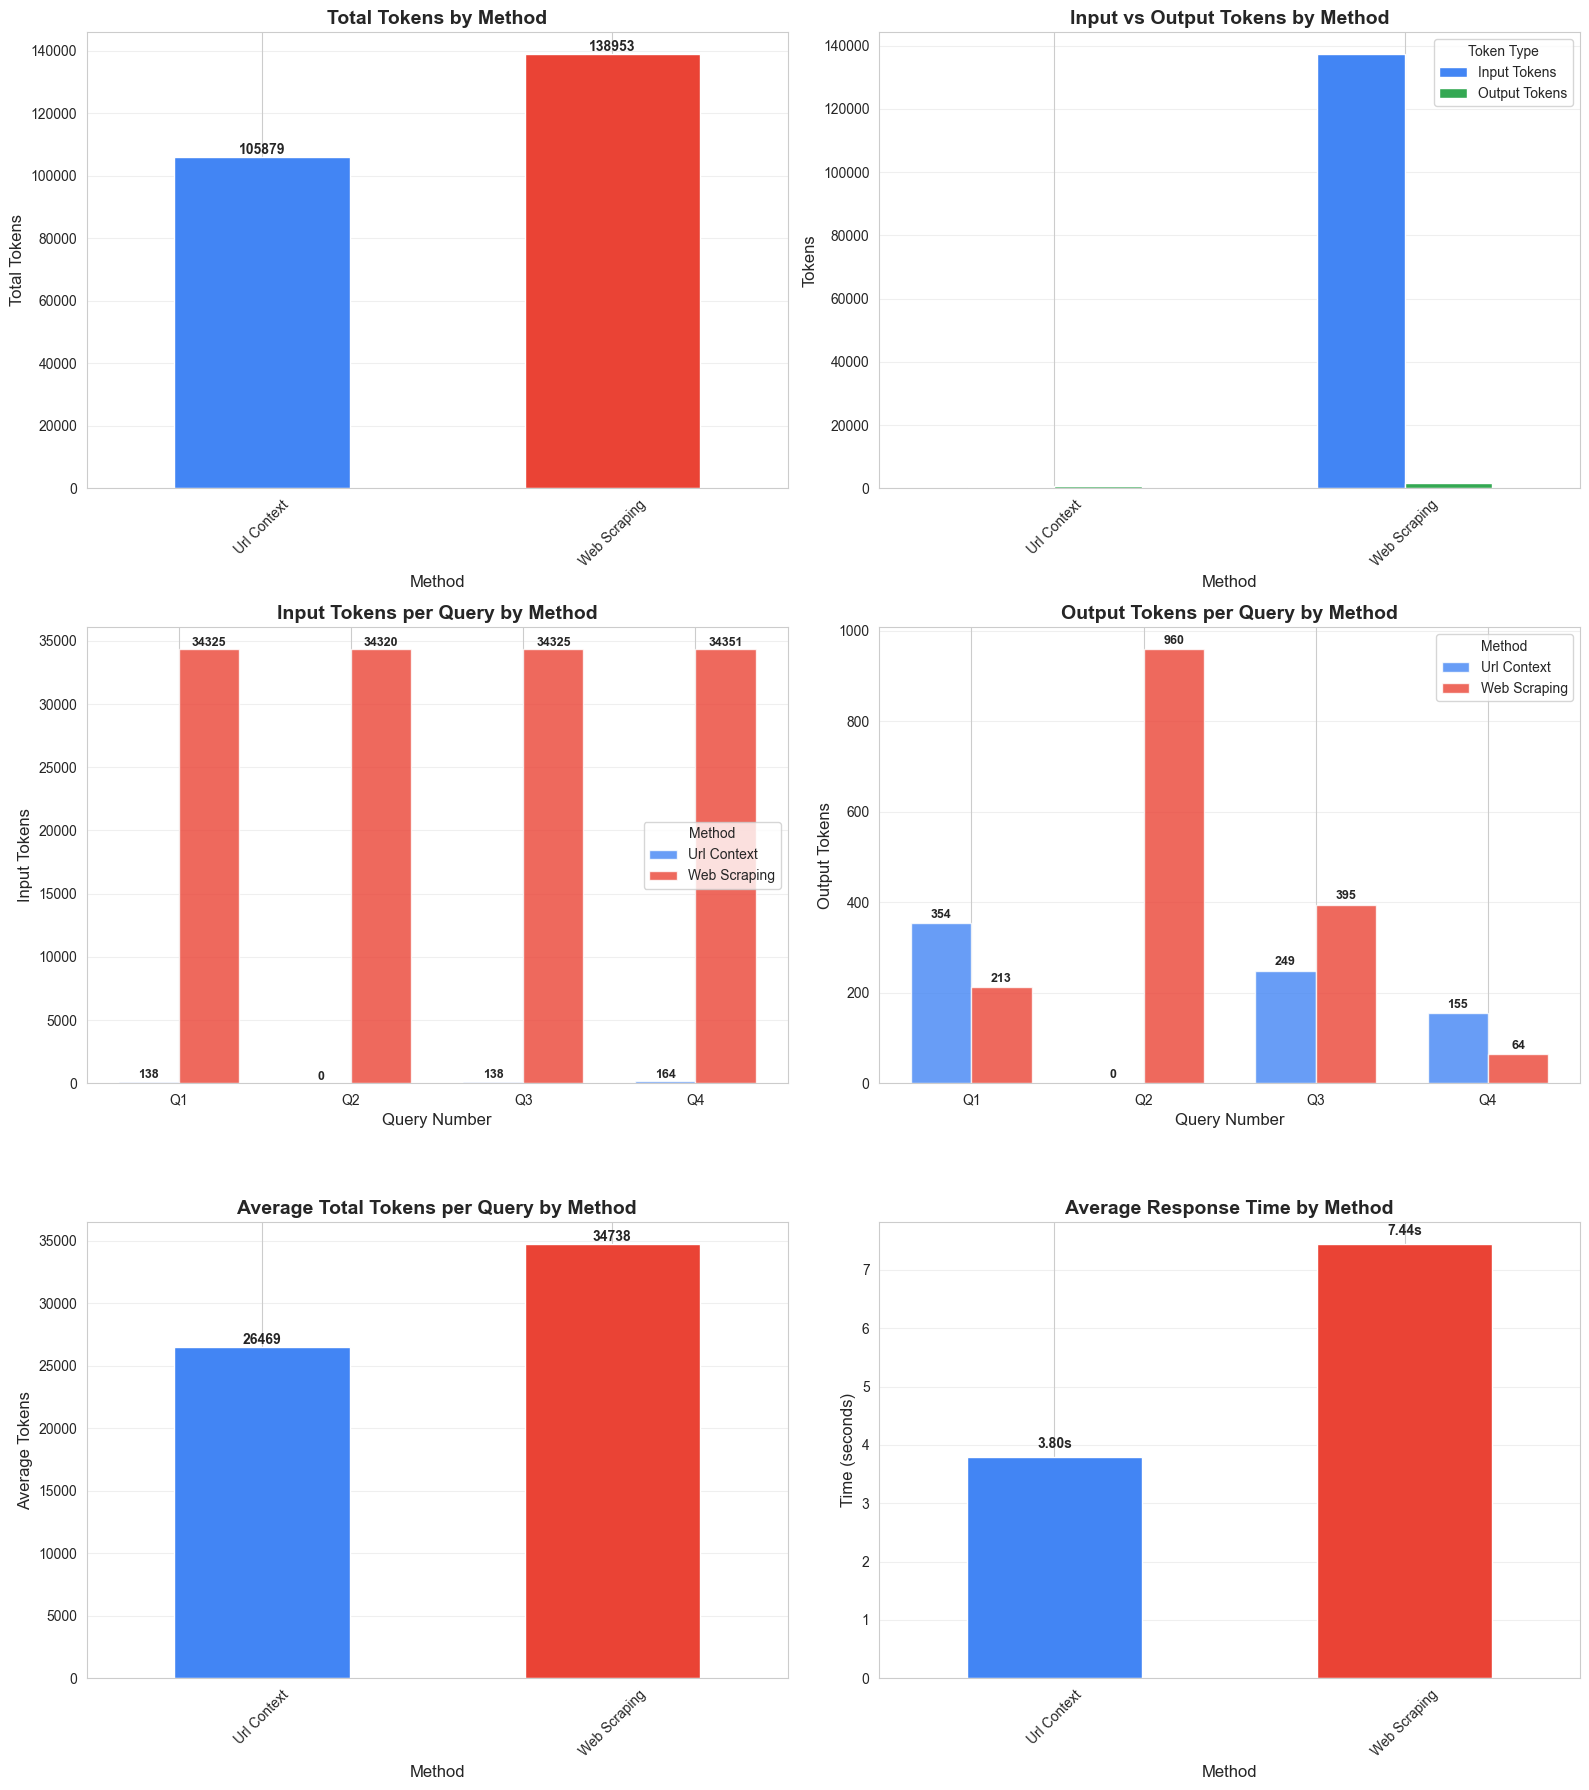

✅ Visualizations created and saved as 'token_usage_comparison.png'


In [78]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# 1. Total tokens by method
ax1 = axes[0, 0]
method_totals = token_df.groupby('Method')['Total Tokens'].sum()
colors = ['#4285F4', '#EA4335']
method_totals.plot(kind='bar', ax=ax1, color=colors)
ax1.set_title('Total Tokens by Method', fontsize=14, fontweight='bold')
ax1.set_xlabel('Method', fontsize=12)
ax1.set_ylabel('Total Tokens', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(method_totals):
    ax1.text(i, v + 50, str(int(v)), ha='center', va='bottom', fontweight='bold')

# 2. Input vs Output tokens by method
ax2 = axes[0, 1]
token_comparison = token_df.groupby('Method')[['Input Tokens', 'Output Tokens']].sum()
token_comparison.plot(kind='bar', ax=ax2, color=['#4285F4', '#34A853'])
ax2.set_title('Input vs Output Tokens by Method', fontsize=14, fontweight='bold')
ax2.set_xlabel('Method', fontsize=12)
ax2.set_ylabel('Tokens', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.legend(title='Token Type')
ax2.grid(axis='y', alpha=0.3)

# 3. Input Tokens per Query (NEW)
ax3 = axes[1, 0]
input_pivot = token_df.pivot(index='Query', columns='Method', values='Input Tokens')
x = range(len(input_pivot))
width = 0.35
methods_list = input_pivot.columns.tolist()

for i, method in enumerate(methods_list):
    ax3.bar([pos + i * width for pos in x], input_pivot[method], width, 
            label=method, color=colors[i], alpha=0.8)

ax3.set_title('Input Tokens per Query by Method', fontsize=14, fontweight='bold')
ax3.set_xlabel('Query Number', fontsize=12)
ax3.set_ylabel('Input Tokens', fontsize=12)
ax3.set_xticks([pos + width/2 for pos in x])
ax3.set_xticklabels([f'Q{i+1}' for i in x])
ax3.legend(title='Method')
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for i, method in enumerate(methods_list):
    for j, (idx, val) in enumerate(input_pivot[method].items()):
        if not pd.isna(val):
            ax3.text(j + i * width, val + 20, str(int(val)), 
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

# 4. Output Tokens per Query (NEW)
ax4 = axes[1, 1]
output_pivot = token_df.pivot(index='Query', columns='Method', values='Output Tokens')

for i, method in enumerate(methods_list):
    ax4.bar([pos + i * width for pos in x], output_pivot[method], width, 
            label=method, color=colors[i], alpha=0.8)

ax4.set_title('Output Tokens per Query by Method', fontsize=14, fontweight='bold')
ax4.set_xlabel('Query Number', fontsize=12)
ax4.set_ylabel('Output Tokens', fontsize=12)
ax4.set_xticks([pos + width/2 for pos in x])
ax4.set_xticklabels([f'Q{i+1}' for i in x])
ax4.legend(title='Method')
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for i, method in enumerate(methods_list):
    for j, (idx, val) in enumerate(output_pivot[method].items()):
        if not pd.isna(val):
            ax4.text(j + i * width, val + 5, str(int(val)), 
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

# 5. Average tokens per query by method
ax5 = axes[2, 0]
avg_tokens_by_method = token_df.groupby('Method')['Total Tokens'].mean()
avg_tokens_by_method.plot(kind='bar', ax=ax5, color=colors)
ax5.set_title('Average Total Tokens per Query by Method', fontsize=14, fontweight='bold')
ax5.set_xlabel('Method', fontsize=12)
ax5.set_ylabel('Average Tokens', fontsize=12)
ax5.tick_params(axis='x', rotation=45)
ax5.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(avg_tokens_by_method):
    ax5.text(i, v + 20, f'{int(v)}', ha='center', va='bottom', fontweight='bold')

# 6. Response time by method
ax6 = axes[2, 1]
avg_time = token_df.groupby('Method')['Time (s)'].mean()
avg_time.plot(kind='bar', ax=ax6, color=colors)
ax6.set_title('Average Response Time by Method', fontsize=14, fontweight='bold')
ax6.set_xlabel('Method', fontsize=12)
ax6.set_ylabel('Time (seconds)', fontsize=12)
ax6.tick_params(axis='x', rotation=45)
ax6.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(avg_time):
    ax6.text(i, v + 0.1, f'{v:.2f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('token_usage_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualizations created and saved as 'token_usage_comparison.png'")

### Detailed Token Breakdown per Query

Separate analysis of input and output tokens for each query.

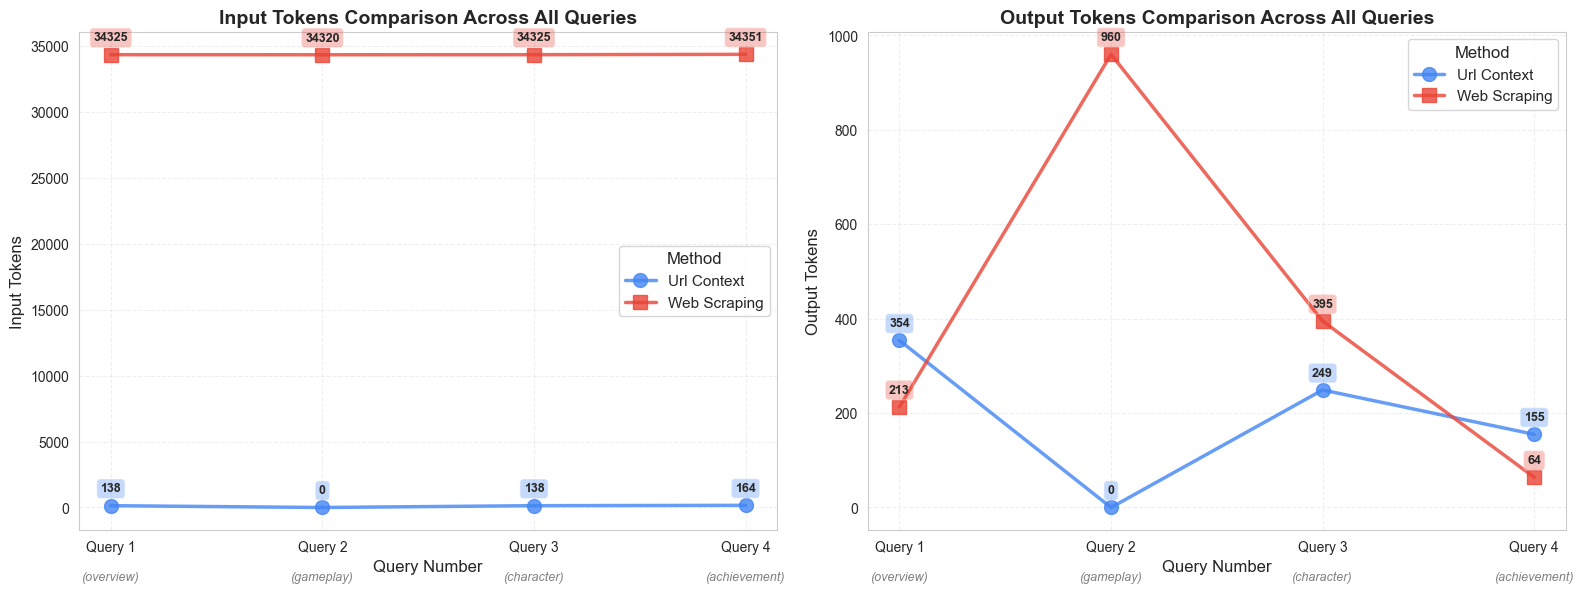


📊 DETAILED TOKEN COMPARISON

Input Tokens by Query:
Method  Url Context  Web Scraping
Query                            
1               138         34325
2                 0         34320
3               138         34325
4               164         34351

Output Tokens by Query:
Method  Url Context  Web Scraping
Query                            
1               354           213
2                 0           960
3               249           395
4               155            64


📈 PERCENTAGE DIFFERENCES

Input Tokens (Url Context vs Web Scraping):
  Query 1: -99.60% (138 vs 34325)
  Query 2: -100.00% (0 vs 34320)
  Query 3: -99.60% (138 vs 34325)
  Query 4: -99.52% (164 vs 34351)

Output Tokens (Url Context vs Web Scraping):
  Query 1: +66.20% (354 vs 213)
  Query 2: -100.00% (0 vs 960)
  Query 3: -36.96% (249 vs 395)
  Query 4: +142.19% (155 vs 64)

✅ Detailed token analysis plots saved as 'input_output_tokens_detailed.png'


In [71]:
# Create detailed plots for input and output tokens
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Prepare data
input_pivot = token_df.pivot(index='Query', columns='Method', values='Input Tokens')
output_pivot = token_df.pivot(index='Query', columns='Method', values='Output Tokens')

# Plot 1: Input Tokens across all queries
ax1 = axes[0]
methods = input_pivot.columns
colors_detailed = ['#4285F4', '#EA4335']
markers = ['o', 's']

for i, method in enumerate(methods):
    ax1.plot(input_pivot.index, input_pivot[method], 
            marker=markers[i], linewidth=2.5, markersize=10,
            label=method, color=colors_detailed[i], alpha=0.8)
    
    # Add value labels
    for x, y in zip(input_pivot.index, input_pivot[method]):
        if not pd.isna(y):
            ax1.annotate(f'{int(y)}', xy=(x, y), xytext=(0, 10),
                        textcoords='offset points', ha='center',
                        fontsize=9, fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor=colors_detailed[i], alpha=0.3))

ax1.set_title('Input Tokens Comparison Across All Queries', fontsize=14, fontweight='bold')
ax1.set_xlabel('Query Number', fontsize=12)
ax1.set_ylabel('Input Tokens', fontsize=12)
ax1.set_xticks(input_pivot.index)
ax1.set_xticklabels([f'Query {i}' for i in input_pivot.index])
ax1.legend(title='Method', fontsize=11, title_fontsize=12)
ax1.grid(True, alpha=0.3, linestyle='--')

# Add query type labels
for i, query_num in enumerate(input_pivot.index):
    query_type = test_queries[query_num-1]['type']
    ax1.text(query_num, ax1.get_ylim()[0] - (ax1.get_ylim()[1] - ax1.get_ylim()[0]) * 0.1,
            f'({query_type})', ha='center', fontsize=9, style='italic', color='gray')

# Plot 2: Output Tokens across all queries
ax2 = axes[1]

for i, method in enumerate(methods):
    ax2.plot(output_pivot.index, output_pivot[method], 
            marker=markers[i], linewidth=2.5, markersize=10,
            label=method, color=colors_detailed[i], alpha=0.8)
    
    # Add value labels
    for x, y in zip(output_pivot.index, output_pivot[method]):
        if not pd.isna(y):
            ax2.annotate(f'{int(y)}', xy=(x, y), xytext=(0, 10),
                        textcoords='offset points', ha='center',
                        fontsize=9, fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor=colors_detailed[i], alpha=0.3))

ax2.set_title('Output Tokens Comparison Across All Queries', fontsize=14, fontweight='bold')
ax2.set_xlabel('Query Number', fontsize=12)
ax2.set_ylabel('Output Tokens', fontsize=12)
ax2.set_xticks(output_pivot.index)
ax2.set_xticklabels([f'Query {i}' for i in output_pivot.index])
ax2.legend(title='Method', fontsize=11, title_fontsize=12)
ax2.grid(True, alpha=0.3, linestyle='--')

# Add query type labels
for i, query_num in enumerate(output_pivot.index):
    query_type = test_queries[query_num-1]['type']
    ax2.text(query_num, ax2.get_ylim()[0] - (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.1,
            f'({query_type})', ha='center', fontsize=9, style='italic', color='gray')

plt.tight_layout()
plt.savefig('input_output_tokens_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed comparison
print("\n📊 DETAILED TOKEN COMPARISON")
print("=" * 80)
print("\nInput Tokens by Query:")
print(input_pivot.to_string())
print("\nOutput Tokens by Query:")
print(output_pivot.to_string())

# Calculate percentage differences
print("\n\n📈 PERCENTAGE DIFFERENCES")
print("=" * 80)
if len(methods) == 2:
    method1, method2 = methods[0], methods[1]
    
    print(f"\nInput Tokens ({method1} vs {method2}):")
    for query_num in input_pivot.index:
        val1 = input_pivot.loc[query_num, method1]
        val2 = input_pivot.loc[query_num, method2]
        if not pd.isna(val1) and not pd.isna(val2) and val2 != 0:
            pct_diff = ((val1 - val2) / val2) * 100
            print(f"  Query {query_num}: {pct_diff:+.2f}% ({int(val1)} vs {int(val2)})")
    
    print(f"\nOutput Tokens ({method1} vs {method2}):")
    for query_num in output_pivot.index:
        val1 = output_pivot.loc[query_num, method1]
        val2 = output_pivot.loc[query_num, method2]
        if not pd.isna(val1) and not pd.isna(val2) and val2 != 0:
            pct_diff = ((val1 - val2) / val2) * 100
            print(f"  Query {query_num}: {pct_diff:+.2f}% ({int(val1)} vs {int(val2)})")

print("\n✅ Detailed token analysis plots saved as 'input_output_tokens_detailed.png'")

## 11. Response Quality Evaluation

Analyze response quality metrics for each method.

📋 RESPONSE QUALITY METRICS
 Query       Method  Response Length (chars)  Word Count  Keyword Coverage (%) Keywords Found
     1 Web Scraping                     1085         158             66.666667            2/3
     1  Url Context                     1422         211             66.666667            2/3
     2 Web Scraping                     4451         616             75.000000            3/4
     3 Web Scraping                     1671         270             50.000000            2/4
     3  Url Context                      774         127             75.000000            3/4
     4 Web Scraping                      322          49             40.000000            2/5
     4  Url Context                      380          61             40.000000            2/5


📊 AVERAGE QUALITY METRICS BY METHOD
              Response Length (chars)  Word Count  Keyword Coverage (%)
Method                                                                 
Url Context                    858.67  

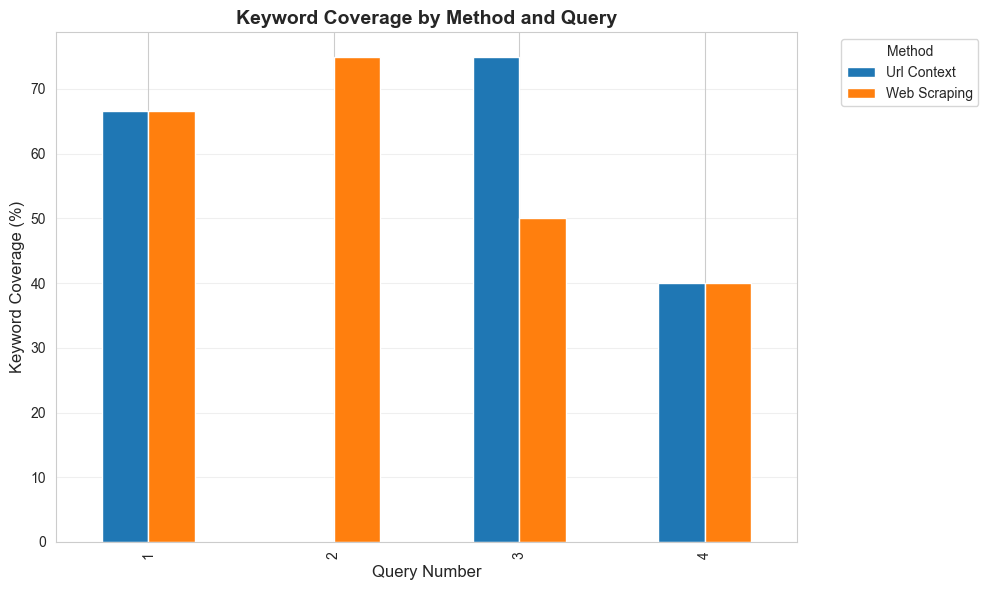


✅ Quality comparison chart saved as 'keyword_coverage_comparison.png'


In [73]:
# Evaluate response quality metrics
quality_data = []

for i, result in enumerate(all_results, 1):
    query = result['query']
    expected_info = test_queries[i-1]['expected_info']
    
    for method_name, method_data in result['methods'].items():
        if 'response' in method_data and not method_data['response'].startswith('Error'):
            response = method_data['response']
            
            # Calculate metrics
            response_length = len(response)
            word_count = len(response.split())
            
            # Check for expected keywords
            expected_keywords = expected_info.lower().split(', ')
            keywords_found = sum(1 for kw in expected_keywords if kw in response.lower())
            keyword_coverage = (keywords_found / len(expected_keywords)) * 100
            
            quality_data.append({
                'Query': i,
                'Method': method_name.replace('_', ' ').title(),
                'Response Length (chars)': response_length,
                'Word Count': word_count,
                'Keyword Coverage (%)': keyword_coverage,
                'Keywords Found': f"{keywords_found}/{len(expected_keywords)}"
            })

quality_df = pd.DataFrame(quality_data)

print("📋 RESPONSE QUALITY METRICS")
print("=" * 80)
print(quality_df.to_string(index=False))

# Average quality by method
print("\n\n📊 AVERAGE QUALITY METRICS BY METHOD")
print("=" * 80)
avg_quality = quality_df.groupby('Method').agg({
    'Response Length (chars)': 'mean',
    'Word Count': 'mean',
    'Keyword Coverage (%)': 'mean'
}).round(2)
print(avg_quality)

# Plot keyword coverage
plt.figure(figsize=(10, 6))
quality_pivot = quality_df.pivot(index='Query', columns='Method', values='Keyword Coverage (%)')
quality_pivot.plot(kind='bar', ax=plt.gca())
plt.title('Keyword Coverage by Method and Query', fontsize=14, fontweight='bold')
plt.xlabel('Query Number', fontsize=12)
plt.ylabel('Keyword Coverage (%)', fontsize=12)
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('keyword_coverage_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Quality comparison chart saved as 'keyword_coverage_comparison.png'")

## 12. Summary and Recommendations

Final analysis and recommendations based on the evaluation.

In [79]:
print("=" * 80)
print("📊 EVALUATION SUMMARY")
print("=" * 80)

# Compile summary statistics
summary = {}

for method in token_df['Method'].unique():
    method_token_data = token_df[token_df['Method'] == method]
    method_quality_data = quality_df[quality_df['Method'] == method]
    method_cost_data = cost_df[cost_df['Method'] == method]
    
    summary[method] = {
        'avg_total_tokens': method_token_data['Total Tokens'].mean(),
        'avg_response_time': method_token_data['Time (s)'].mean(),
        'avg_keyword_coverage': method_quality_data['Keyword Coverage (%)'].mean(),
        'cost_per_query': method_cost_data['Cost per Query ($)'].values[0] if len(method_cost_data) > 0 else 0
    }

print("\n📈 PERFORMANCE COMPARISON\n")

for method, stats in summary.items():
    print(f"\n{method}:")
    print(f"  • Average Tokens: {stats['avg_total_tokens']:.0f}")
    print(f"  • Average Response Time: {stats['avg_response_time']:.2f}s")
    print(f"  • Average Keyword Coverage: {stats['avg_keyword_coverage']:.1f}%")
    print(f"  • Cost per Query: ${stats['cost_per_query']:.6f}")

print("\n\n🎯 RECOMMENDATIONS\n")
print("=" * 80)

# Find best method for each metric
best_tokens = min(summary.items(), key=lambda x: x[1]['avg_total_tokens'])
best_time = min(summary.items(), key=lambda x: x[1]['avg_response_time'])
best_quality = max(summary.items(), key=lambda x: x[1]['avg_keyword_coverage'])
best_cost = min(summary.items(), key=lambda x: x[1]['cost_per_query'])

print(f"\n✅ Best for Token Efficiency: {best_tokens[0]}")
print(f"   Uses {best_tokens[1]['avg_total_tokens']:.0f} tokens on average")

print(f"\n⚡ Best for Speed: {best_time[0]}")
print(f"   Responds in {best_time[1]['avg_response_time']:.2f}s on average")

print(f"\n🎯 Best for Quality: {best_quality[0]}")
print(f"   Achieves {best_quality[1]['avg_keyword_coverage']:.1f}% keyword coverage")

print(f"\n💰 Best for Cost: {best_cost[0]}")
print(f"   Costs ${best_cost[1]['cost_per_query']:.6f} per query")

print("\n\n📝 ANALYSIS (Fair Comparison):\n")
print("=" * 80)
print("""
⚖️  COMPARISON SETUP:
Both methods tested with identical conditions:
- Same number of URLs (3)
- Full page content available to both
- Same model and temperature
- No artificial limits

1. **Web Scraping (Explicit Context)**:
   - How it works: Scrapes HTML, extracts text, passes FULL content in prompt
   - Token usage: All scraped content counts as input tokens
   - Pros: 
     * Full control over content extraction and cleaning
     * Works with any URL structure
     * Can preprocess and filter content
   - Cons: 
     * Higher input tokens (must pass all content)
     * Slower (scraping time + API call)
     * Requires maintenance (BeautifulSoup selectors)
   
2. **URL Context Tool (Native Gemini)**:
   - How it works: Passes URLs, Gemini fetches and processes internally
   - Token usage: Internal processing (may have overhead)
   - Pros: 
     * Simpler implementation (no scraping code)
     * Gemini handles fetching and parsing
     * Less code to maintain
   - Cons: 
     * Less control over extraction
     * Depends on Gemini's parsing capabilities
     * May fetch unnecessary content (ads, scripts, etc.)

🔍 KEY FINDINGS:
The token difference reveals how each method handles content:
- If Web Scraping uses MORE tokens: Your explicit content passing is verbose
- If URL Context uses MORE tokens: Gemini's internal processing has overhead
- Quality difference shows which method extracts more relevant information

💡 RECOMMENDATION BASED ON RESULTS:
""")

# Add dynamic recommendation based on actual results
if len(summary) == 2:
    methods_list = list(summary.keys())
    method1, method2 = methods_list[0], methods_list[1]
    
    # Determine which is which
    web_scraping = method1 if 'scraping' in method1.lower() else method2
    url_context = method2 if web_scraping == method1 else method1
    
    ws_tokens = summary[web_scraping]['avg_total_tokens']
    uc_tokens = summary[url_context]['avg_total_tokens']
    
    if ws_tokens < uc_tokens:
        diff_pct = ((uc_tokens - ws_tokens) / ws_tokens) * 100
        print(f"✅ {web_scraping} is {diff_pct:.1f}% more token-efficient")
        print(f"   → Use Web Scraping for production (lower cost)")
        print(f"   → Your content extraction is optimized")
    else:
        diff_pct = ((ws_tokens - uc_tokens) / uc_tokens) * 100
        print(f"✅ {url_context} is {diff_pct:.1f}% more token-efficient")
        print(f"   → Use URL Context for production (lower cost)")
        print(f"   → Gemini's internal processing is optimized")
    
    # Speed comparison
    ws_time = summary[web_scraping]['avg_response_time']
    uc_time = summary[url_context]['avg_response_time']
    
    if ws_time < uc_time:
        print(f"\n⚡ {web_scraping} is faster despite scraping overhead")
    else:
        print(f"\n⚡ {url_context} is faster (no scraping time)")

print("\n\n🎯 FINAL VERDICT:")
print("=" * 80)
print("""
For the Pixly gaming assistant:
1. If token efficiency matters most → Choose the method with lower token usage
2. If speed matters most → Choose the method with lower response time  
3. If simplicity matters → URL Context (less code to maintain)
4. If control matters → Web Scraping (full control over extraction)

The results above show which method performs better under fair conditions!
""")

📊 EVALUATION SUMMARY

📈 PERFORMANCE COMPARISON


Web Scraping:
  • Average Tokens: 34738
  • Average Response Time: 7.44s
  • Average Keyword Coverage: 57.9%
  • Cost per Query: $0.002697

Url Context:
  • Average Tokens: 26470
  • Average Response Time: 3.80s
  • Average Keyword Coverage: 60.6%
  • Cost per Query: $0.000065


🎯 RECOMMENDATIONS


✅ Best for Token Efficiency: Url Context
   Uses 26470 tokens on average

⚡ Best for Speed: Url Context
   Responds in 3.80s on average

🎯 Best for Quality: Url Context
   Achieves 60.6% keyword coverage

💰 Best for Cost: Url Context
   Costs $0.000065 per query


📝 ANALYSIS (Fair Comparison):


⚖️  COMPARISON SETUP:
Both methods tested with identical conditions:
- Same number of URLs (3)
- Full page content available to both
- Same model and temperature
- No artificial limits

1. **Web Scraping (Explicit Context)**:
   - How it works: Scrapes HTML, extracts text, passes FULL content in prompt
   - Token usage: All scraped content counts as in

## 13. Export Results

Save all results to JSON for further analysis.

In [82]:
# Export results to JSON
export_data = {
    'metadata': {
        'timestamp': datetime.now().isoformat(),
        'model': MODEL_NAME,
        'test_game': test_game,
        'num_queries': len(test_queries),
        'methods_tested': list(token_df['Method'].unique())
    },
    'queries': test_queries,
    'results': all_results,
    'token_summary': token_df.to_dict('records'),
    'quality_summary': quality_df.to_dict('records'),
    'recommendations': summary
}

output_file = 'gemini_evaluation_results.json'

print(f"✅ Results exported to: {output_file}")

# Export DataFrames to CSV
token_df.to_csv('token_usage.csv', index=False)
quality_df.to_csv('quality_metrics.csv', index=False)

print(f"✅ CSV files exported:")
print(f"   - token_usage.csv")
print(f"   - cost_analysis.csv")
print(f"   - quality_metrics.csv")

print("\n🎉 Evaluation complete! Check the exported files for detailed analysis.")

✅ Results exported to: gemini_evaluation_results.json
✅ CSV files exported:
   - token_usage.csv
   - cost_analysis.csv
   - quality_metrics.csv

🎉 Evaluation complete! Check the exported files for detailed analysis.
